In [54]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
from sklearn.cluster import KMeans
from pykalman import KalmanFilter 
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt          
%matplotlib inline
#%matplotlib notebook
#import mpld3

In [55]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv (open/high/low/close/volume) data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [56]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=86400)
#one day in seconds
df['ds'] = pd.to_datetime(df['date'], unit='s')
df['y'] = df['weightedAverage']

In [57]:
def fitKCA(t,z,q,fwd=0):
    """
        Inputs:
        t: Iterable with time indices
        z: Iterable with measurements
        q: Scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (optional, default=0)
        Output:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    """
    #1) Set up matrices A,H and a seed for Q
    h = (t[-1]-t[0])/t.shape[0]
    A=np.array([[1,h,.5*h**2],
               [0,1,h],
               [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2)Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)
    #3) EM estimates
    kf = kf.em(z)
    #4) Smooth
    x_mean,x_covar = kf.smooth(z)
    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1], \
                                          filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
    #6) Std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1) 
    for i in range(1,x_covar.shape[1]): 
        x_std_=x_covar[:,i,i]**.5 
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1) 
    return x_mean,x_std,x_covar

In [58]:
x_mean,x_std,x_covar=fitKCA(df.date.values,df.y.values,1)

/anaconda3/lib/python3.6/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]


In [59]:
fitKCA(df.date.values,df.y.values,1)

/anaconda3/lib/python3.6/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]


(array([[ 4.60704393e+02,  7.15282594e-04,  9.23481853e-08],
        [ 8.65989608e+02,  4.00048233e-03, -7.87911297e-08],
        [ 9.17932896e+02, -9.29380987e-04,  1.55323062e-08],
        ...,
        [ 6.32304014e+03,  9.28635008e-04,  8.95386695e-09],
        [ 6.43645873e+03,  1.35067060e-03, -8.27431010e-09],
        [ 6.52218486e+03,  6.36915896e-04, -8.27430993e-09]]),
 array([[7.06051932e-01, 9.48061877e-01, 2.19811016e-05],
        [7.49831577e+01, 3.73864805e+00, 8.66816905e-05],
        [6.07365916e+01, 3.86461692e+00, 8.96023157e-05],
        ...,
        [6.07365921e+01, 4.04188671e+00, 9.37123710e-05],
        [6.07365930e+01, 4.65863003e+00, 1.08011756e-04],
        [6.07365939e+01, 6.96372029e+00, 2.22326595e-04]]),
 array([[[ 4.98509331e-01, -9.22805796e-07, -1.12593386e-10],
         [-9.22805796e-07,  8.98821323e-01, -2.08394455e-05],
         [-1.12593386e-10, -2.08394455e-05,  4.83168827e-10]],
 
        [[ 5.62247394e+03, -3.49330566e-03, -1.43021044e-06],
     

In [60]:
print(x_mean)

[[ 4.60704393e+02  7.15282594e-04  9.23481853e-08]
 [ 8.65989608e+02  4.00048233e-03 -7.87911297e-08]
 [ 9.17932896e+02 -9.29380987e-04  1.55323062e-08]
 ...
 [ 6.32304014e+03  9.28635008e-04  8.95386695e-09]
 [ 6.43645873e+03  1.35067060e-03 -8.27431010e-09]
 [ 6.52218486e+03  6.36915896e-04 -8.27430993e-09]]


In [61]:
# Mean Acceleration

In [62]:
print(x_mean[0,2])

9.234818527398104e-08


In [63]:
# Std Acceleration

In [64]:
print(x_std[0,2])

2.1981101593198066e-05


In [65]:
# Mean Velocity/Inertia

In [66]:
print(x_mean[0,1])

0.0007152825936128129


In [67]:
# Std Velocity/Inertia

In [68]:
print(x_std[0,1])

0.9480618770411042


## Figure 1: KCA estimated mean states

Text(0.5,1,'Measurements: Weighted Average Prices')

TypeError: Object of type 'ndarray' is not JSON serializable

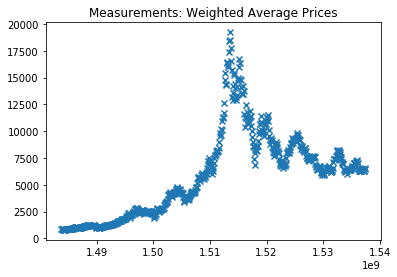

In [69]:
#measurements
plt.scatter(df.date, df.weightedAverage,marker='x')
plt.title('Measurements: Weighted Average Prices')

Text(0.5,1,'Position')

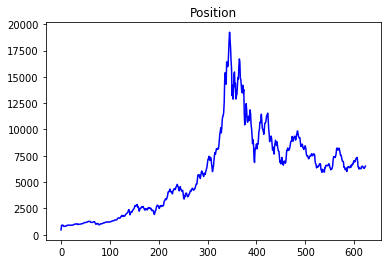

In [70]:
plt.plot(x_mean[:,0],color='blue') 
plt.title('Position')

Text(0.5,1,'Velocity')

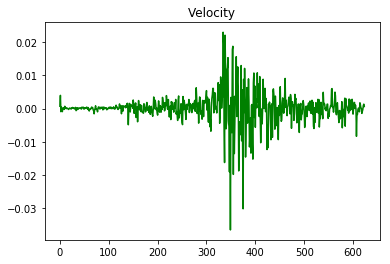

In [71]:
#velocity
plt.plot(x_mean[:,1],color='green') 
plt.title('Velocity')

Text(0.5,1,'Acceleration')

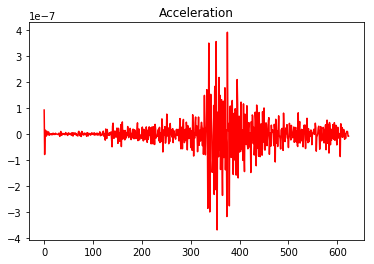

In [72]:
#acceleration
plt.plot(x_mean[:,2],color='red')
plt.title('Acceleration')

In [73]:
# couldn't get axis ranges to change, even after doing what this indicated:
# https://stackoverflow.com/questions/7733693/matplotlib-overlay-plots-with-different-scales
# will play around more in the days to come

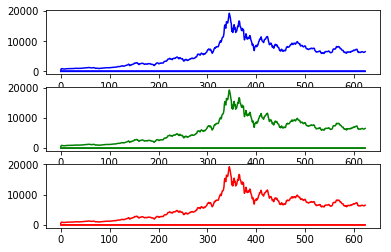

In [74]:
fig, axes = plt.subplots(nrows=3)

colors = ('b', 'g', 'r')
for ax, color in zip(axes, colors):
    #data = np.random.random(1) * np.random.random(10)
    ax.plot(x_mean[:,0],color=color)
    ax.plot(x_mean[:,1],color=color)
    ax.plot(x_mean[:,2],color=color)
    #ax.plot(data, marker='o', linestyle='none', color=color)

plt.show()

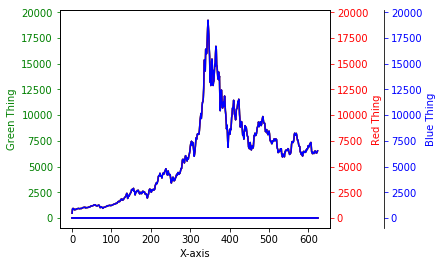

In [76]:
# To make things reproducible...
np.random.seed(1977)

fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]
# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)
# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.2))
# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

# And finally we get to plot things...
colors = ('Green', 'Red', 'Blue')
for ax, color in zip(axes, colors):
    ax.plot(x_mean[:,0],color=color)
    ax.plot(x_mean[:,1],color=color)
    ax.plot(x_mean[:,2],color=color)
    #data = np.random.random(1) * np.random.random(10)
    #ax.plot(data, marker='o', linestyle='none', color=color)
    ax.set_ylabel('%s Thing' % color, color=color)
    ax.tick_params(axis='y', colors=color)
axes[0].set_xlabel('X-axis')

plt.show()

## Figure 2 (shows that FFT extracts a signal very similar to the first state component extracted by KCA) 

In [77]:
# Not sure how to display this better...zooming in still doesn't show detail as in the paper

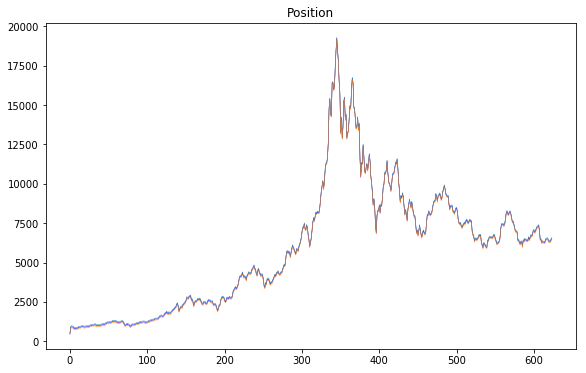

In [78]:
#mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = [9.5,6] #width,height
#position
upper_error_bars = x_mean[:,0] + x_std[:,0]
lower_error_bars = x_mean[:,0] - x_std[:,0]
plt.plot(x_mean[:,0],color='blue',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)
plt.title('Position')
plt.show()

Text(0.5,1,'Velocity')

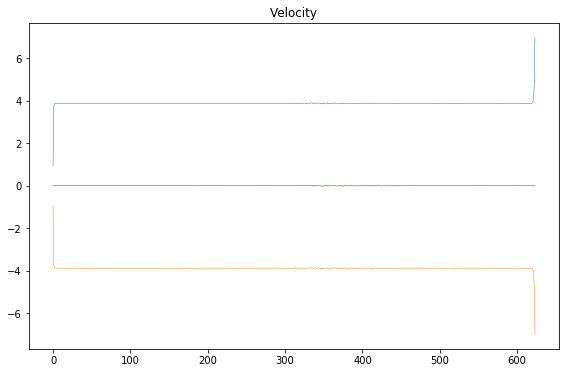

In [79]:
#velocity

upper_error_bars = x_mean[:,1] + x_std[:,1]
lower_error_bars = x_mean[:,1] - x_std[:,1]

plt.plot(x_mean[:,1],color='green',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)

plt.title('Velocity')

Text(0.5,1,'Acceleration')

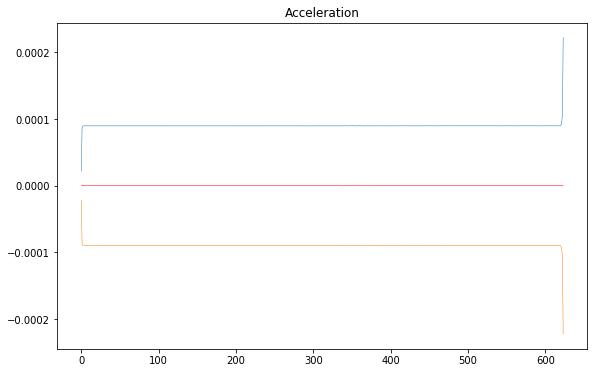

In [80]:
#acceleration

upper_error_bars = x_mean[:,2] + x_std[:,2]
lower_error_bars = x_mean[:,2] - x_std[:,2]

plt.plot(x_mean[:,2],color='red',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)

plt.title('Acceleration')

## Estimated Position vs Price

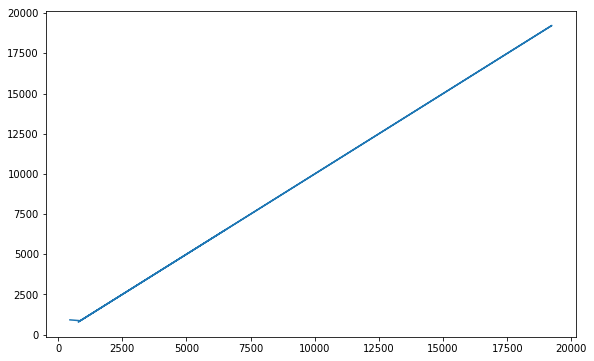

In [81]:
plt.plot(x_mean[:,0],df.weightedAverage)
#plt.plot(x_mean[:,0], color='b', linewidth=.45)
#plt.plot(df.weightedAverage, color='y',linewidth=.45)

In [82]:
# This linear relationship indicates that the estimated position and price values were practically equal 
# after the beginning period.

## Prophet on DF with only inertia and accel. 

In [89]:
m = Prophet(seasonality_mode='multiplicative')

In [90]:
df2 = pd.DataFrame()
df2['ds'] = x_mean[:,1] #velocity
df2['y'] = x_mean[:,2] #inertia

In [91]:
m.fit(df2)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/timedeltas.py:409: RuntimeWarning: invalid value encountered in true_divide
  result = op(left, np.float64(right))
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


RuntimeError: Initialization failed.

In [ ]:
future = m.make_future_dataframe(periods=30) 
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast)